In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
TSV_PATH = "gadm1_nuts3_counties-gadm1_nuts3_counties - FB Social Connectedness Index - October 2021.tsv"
MAP_PATH = "gadm1_nuts3_counties_levels.csv"

In [4]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

In [5]:
# lettura TSV SCI (Facebook) ---
sci_cols = ["user_loc", "fr_loc", "scaled_sci"]
dtype_map = {"user_loc": "string", "fr_loc": "string", "scaled_sci": "float64"}

df_sci = pd.read_csv(
    TSV_PATH,
    sep="\t",
    usecols=sci_cols,
    dtype=dtype_map,
    low_memory=False
)

print("== SCI (TSV) – prime righe ==")
display(df_sci.head())
print("\nSchema:")
print(df_sci.dtypes)
print(f"\nNumero righe: {len(df_sci):,}")


== SCI (TSV) – prime righe ==


,user_loc,fr_loc,scaled_sci
0,ABW,ABW,11264841.0
1,ABW,AGO1,38.0
2,ABW,AGO10,34.0
3,ABW,AGO11,32.0
4,ABW,AGO12,23.0



Schema:
user_loc      string[python]
fr_loc        string[python]
scaled_sci           float64
dtype: object

Numero righe: 63,824,121


In [6]:
# lettura file mapping con i nomi reali
df_map = pd.read_csv(
    MAP_PATH,
    usecols=["key", "level"],
    dtype="string"
)

df_map = df_map.rename(columns={"key": "location_code", "level": "level_type"})

print("== Mapping livelli – prime righe ==")
display(df_map.head())
print("\nSchema:")
print(df_map.dtypes)

== Mapping livelli – prime righe ==


,location_code,level_type
0,AND,country
1,ATG,country
2,ABW,country
3,BHS,country
4,BRB,country



Schema:
location_code    string[python]
level_type       string[python]
dtype: object


In [7]:
required_sci_cols = ["user_loc", "fr_loc", "scaled_sci"] 
missing_sci = set(required_sci_cols) - set(df_sci.columns)
assert not missing_sci, f"Mancano colonne nel TSV SCI: {missing_sci}"

required_map_cols = ["location_code", "level_type"]
missing_map = set(required_map_cols) - set(df_map.columns)
assert not missing_map, f"Mancano colonne nel mapping: {missing_map}"

null_counts = df_sci[required_sci_cols].isna().sum()
print("Valori nulli in SCI:\n", null_counts)


Valori nulli in SCI:
 user_loc      0
fr_loc        0
scaled_sci    0
dtype: int64


In [8]:
# copertura del mapping sulle location del TSV ---
unique_locs = pd.unique(pd.concat([df_sci["user_loc"], df_sci["fr_loc"]], ignore_index=True))
coverage = pd.DataFrame({"location_code": unique_locs}).merge(
    df_map, on="location_code", how="left"
)
coverage["known"] = coverage["level_type"].notna()

known_ratio = coverage["known"].mean()
print(f"Copertura mapping (location conosciute): {known_ratio:.1%} ({coverage['known'].sum()}/{len(coverage)})")

if known_ratio < 0.95:  
    print("Esempi *non* mappati:")
    display(coverage.loc[~coverage["known"]].head(10))


Copertura mapping (location conosciute): 99.9% (7984/7989)


In [9]:
# check incrocio - quante righe hanno entrambi i capi mappati
m_user = df_sci.merge(
    df_map.rename(columns={"location_code": "user_loc", "level_type": "user_level_type"}),
    on="user_loc", how="left"
)
m_both = m_user.merge(
    df_map.rename(columns={"location_code": "fr_loc", "level_type": "fr_level_type"}),
    on="fr_loc", how="left"
)

both_known = m_both["user_level_type"].notna() & m_both["fr_level_type"].notna()
print(f"Righe SCI con entrambi (user_loc, fr_loc) mappati: {both_known.sum()}/{len(m_both)} ({both_known.mean():.1%})")

# examples
cols_show = ["user_loc", "user_level_type", "fr_loc", "fr_level_type", "scaled_sci"]
display(m_both.loc[both_known, cols_show].head(10))


Righe SCI con entrambi (user_loc, fr_loc) mappati: 63744256/63824121 (99.9%)


,user_loc,user_level_type,fr_loc,fr_level_type,scaled_sci
0,ABW,country,ABW,country,11264841.0
1,ABW,country,AGO1,gadm1,38.0
2,ABW,country,AGO10,gadm1,34.0
3,ABW,country,AGO11,gadm1,32.0
4,ABW,country,AGO12,gadm1,23.0
5,ABW,country,AGO13,gadm1,37.0
6,ABW,country,AGO14,gadm1,30.0
7,ABW,country,AGO15,gadm1,26.0
8,ABW,country,AGO16,gadm1,43.0
9,ABW,country,AGO17,gadm1,29.0


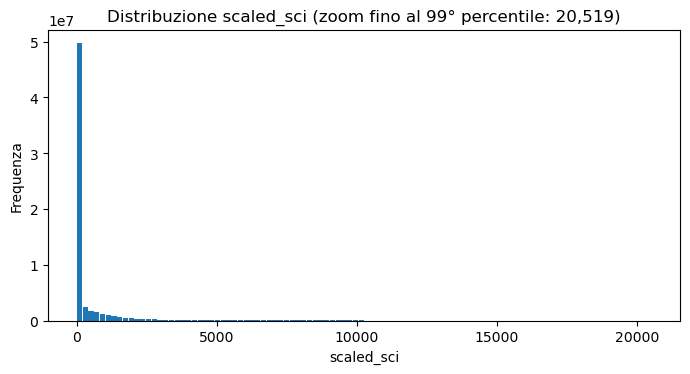

In [10]:
import numpy as np

vals = df_sci["scaled_sci"].dropna().astype(float)
p99 = np.percentile(vals, 99)

plt.figure(figsize=(7,4))
plt.hist(vals[vals <= p99], bins=100, rwidth=0.9)
plt.title(f"Distribuzione scaled_sci (zoom fino al 99° percentile: {p99:,.0f})")
plt.xlabel("scaled_sci")
plt.ylabel("Frequenza")
plt.tight_layout()
plt.show()


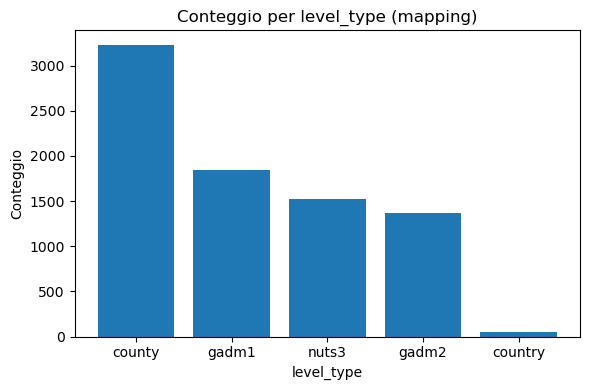

In [11]:
# Conta i valori dei tipi
counts = df_map["level_type"].value_counts(dropna=False)

plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Conteggio per level_type (mapping)")
plt.xlabel("level_type")
plt.ylabel("Conteggio")
plt.tight_layout()
plt.show()


In [12]:
# top 10 coppie per SCI (sanity check) ---
top_pairs = df_sci.sort_values("scaled_sci", ascending=False).head(10)
display(top_pairs)


,user_loc,fr_loc,scaled_sci
50344990,USA31005,USA31005,1.000000e+09
50153230,USA30069,USA30069,9.082725e+08
50009410,USA30033,USA30033,6.052468e+08
50688560,USA31091,USA31091,5.827890e+08
50736500,USA31103,USA31103,5.596415e+08
57887550,USA48155,USA48155,5.563044e+08
58319010,USA48263,USA48263,5.518134e+08
50313030,USA30109,USA30109,5.423879e+08
56225630,USA46063,USA46063,5.241536e+08
50624640,USA31075,USA31075,4.839074e+08
